this notebook shows how to compute response-triggered average using `strflab`. Apart from standard scientific Python pacakges, it also requires [ImaGen](https://github.com/ioam/imagen).

Check `/tests/test_rta.py` for a better written version of this demo.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from strflab import preprocessing, rta
import imagen as ig
from collections import OrderedDict
from numpy.linalg import norm, svd, matrix_rank

In [2]:
# first, generate a 2D gabor as kernel to recover
kernel_shape = (8,8)
kernel_to_recover = ig.Gabor(frequency=2, phase=np.pi/3, xdensity=kernel_shape[1], ydensity=kernel_shape[0], size=0.5, orientation=np.pi/6)()

-0.355657460846 0.469551707736


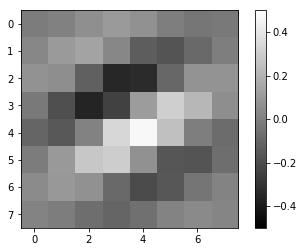

In [3]:
plt.imshow(kernel_to_recover, vmin=-0.5, vmax=0.5, cmap='gray')
plt.colorbar()
print(kernel_to_recover.min(), kernel_to_recover.max())

In [4]:
# ok. let's generate some white input.
rng_state = np.random.RandomState(seed=0)
stim_in = rng_state.randn(100000, kernel_to_recover.size)

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [6]:
# let's try three different nonlinearites.
stim_out_linear = stim_in@kernel_to_recover.ravel()
out_dict = OrderedDict()

# square
out_dict['square'] = stim_out_linear*2
# 0, 1 at threshold of 0
out_dict['threshold'] = np.where(stim_out_linear>=0, 1, 0)
# sigmoid
out_dict['sigmoid'] = sigmoid(stim_out_linear)
# relu
out_dict['relu'] = np.where(stim_out_linear>=0, stim_out_linear, 0)

In [7]:
# ok. let's try to recover

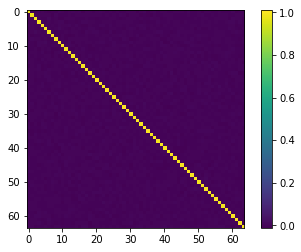

In [8]:
# cov is diagonal.
plt.imshow(preprocessing.cov_matrix(stim_in))
plt.colorbar()

In [9]:
def norm_vector(x):
    assert x.ndim==1
    return x/norm(x)

def cos_between(v1,v2):
    assert v1.ndim == v2.ndim == 1
    return np.dot(v1,v2)/norm(v1)/norm(v2)

(1, 1, 8, 8)


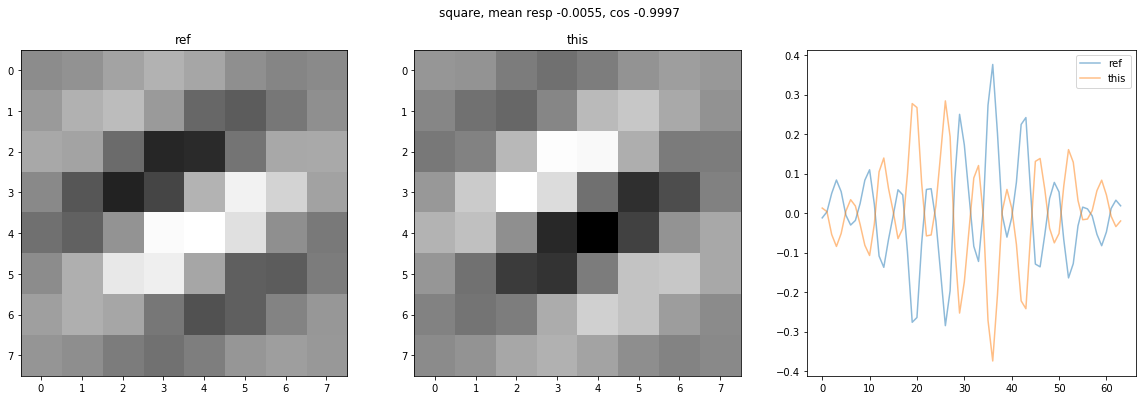

(1, 1, 8, 8)


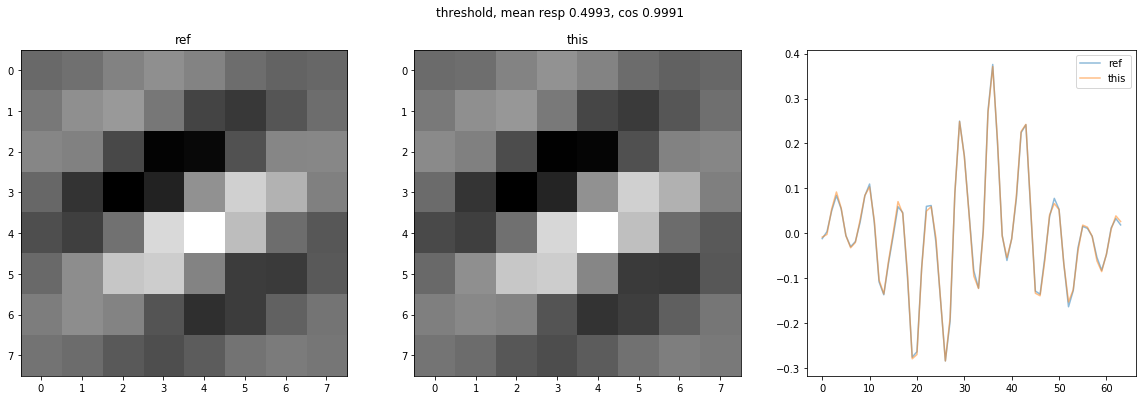

(1, 1, 8, 8)


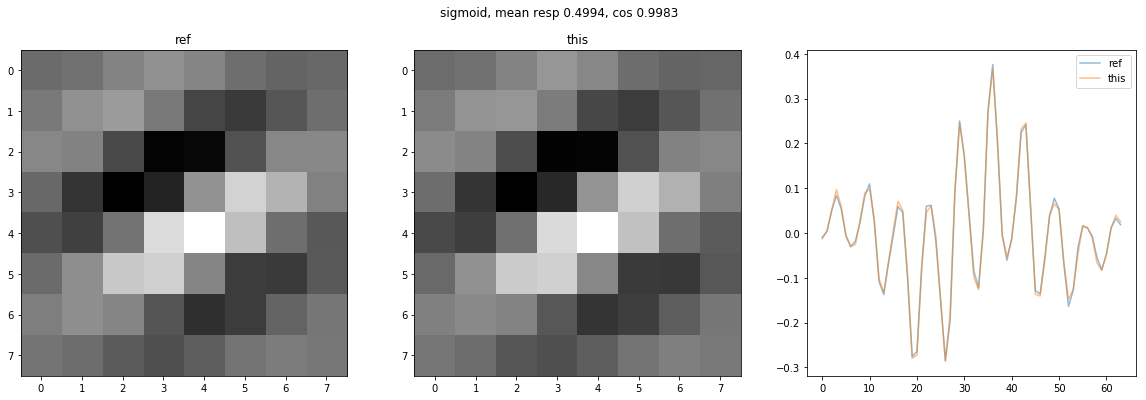

(1, 1, 8, 8)


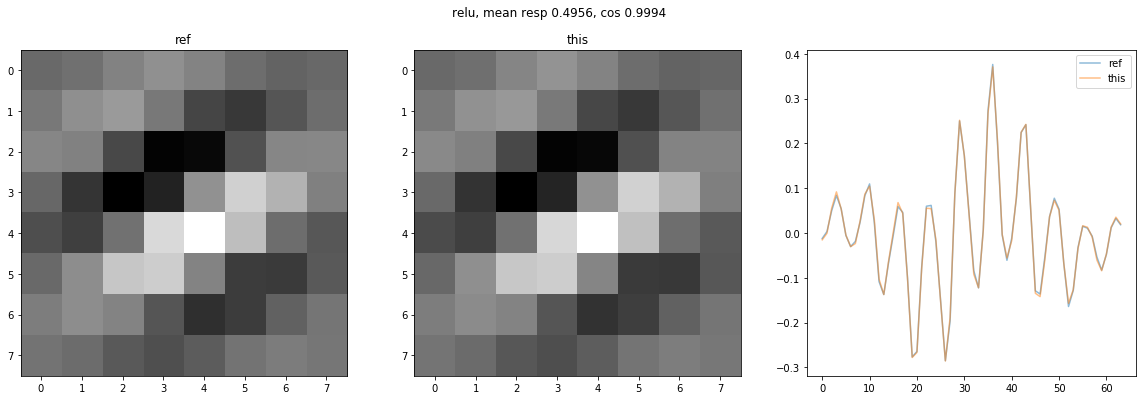

In [10]:
def rta_white_data():
    for out_name, out_this in out_dict.items():
        rta_this = rta.rta(stim_in, out_this[:,np.newaxis])
        rta_reshaped = preprocessing.reshape_kernel(rta_this, kernel_shape, 1, 1, False)
        print(rta_reshaped.shape)
        # compute cosine between recovered and original
        this_one = norm_vector(rta_reshaped.ravel()).reshape(rta_reshaped.shape)[0,0]
        ref_one = norm_vector(kernel_to_recover.ravel()).reshape(kernel_to_recover.shape)
        # show two kernels (normalized)
        plt.close('all')
        fig, axes = plt.subplots(1,3, figsize=(20, 6))
        # min max
        vmin = min(this_one.min(), ref_one.min())
        vmax = min(this_one.max(), ref_one.max())
        fig.suptitle('{}, mean resp {:.4f}, cos {:.4f}'.format(out_name, out_this.mean(), cos_between(this_one.ravel(), ref_one.ravel())))
        axes[0].imshow(ref_one, cmap='gray', vmin=vmin, vmax=vmax)
        axes[0].set_title('ref')
        axes[1].imshow(this_one, cmap='gray', vmin=vmin, vmax=vmax)
        axes[1].set_title('this')
        axes[2].plot(ref_one.ravel(),label='ref', alpha=0.5)
        axes[2].plot(this_one.ravel(),label='this', alpha=0.5)
        axes[2].legend()
        plt.show()
        
rta_white_data()

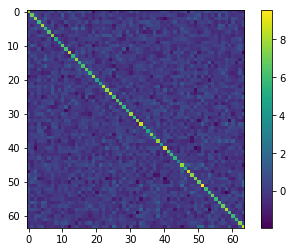

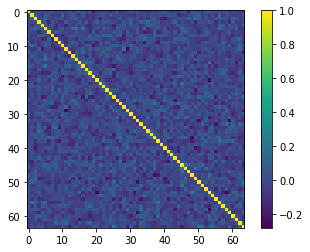

In [11]:
# try correlated data.
def generate_correlation_matrix(size):
    # <https://math.stackexchange.com/questions/357980/how-to-generate-random-symmetric-positive-definite-matrices-using-matlab
    rng_state.seed(0)
    mix_cov = rng_state.randn(size, size)
    mix_cov = mix_cov*mix_cov.T + np.diag(rng_state.rand(size)*0.00001)
    # then svd
    U, S, Vh = svd(mix_cov)
    return (U@np.diag(S**0.5)).T
    #stim_in_non_white = stim_in
transform_matrix = generate_correlation_matrix(np.product(np.asarray(kernel_shape)))
assert matrix_rank(transform_matrix) == np.product(np.asarray(kernel_shape))
stim_in_nonwhite = stim_in@transform_matrix

# cov is diagonal.
plt.close('all')
plt.imshow(preprocessing.cov_matrix(stim_in_nonwhite))
plt.colorbar()
plt.show()
plt.close('all')
plt.imshow(np.corrcoef(stim_in_nonwhite, rowvar=False))
plt.colorbar()
plt.show()

(1, 1, 8, 8)


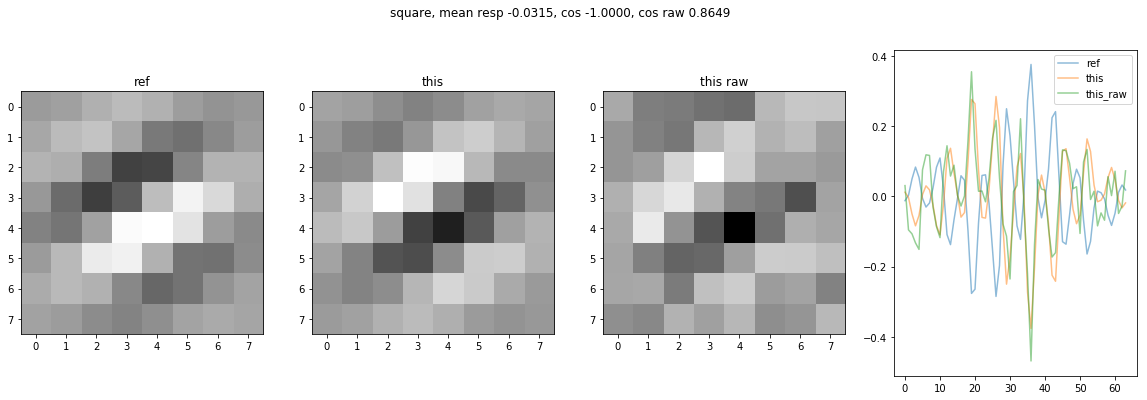

(1, 1, 8, 8)


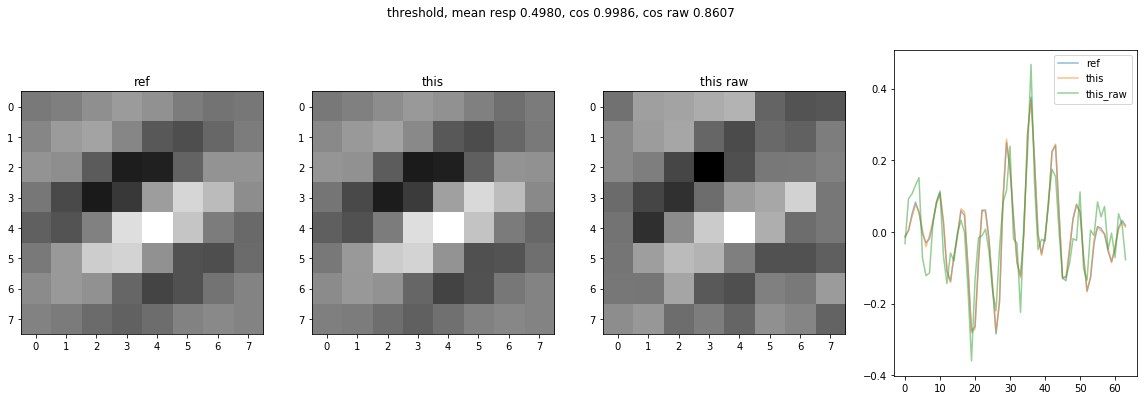

(1, 1, 8, 8)


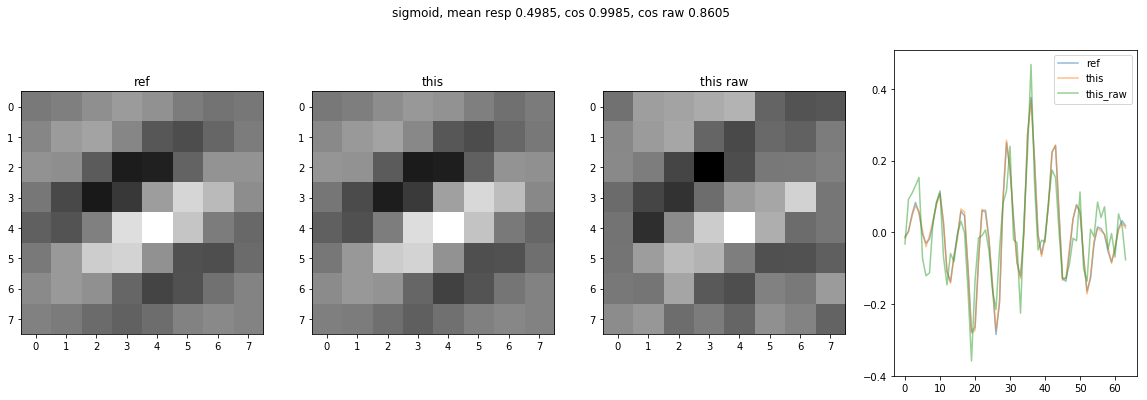

(1, 1, 8, 8)


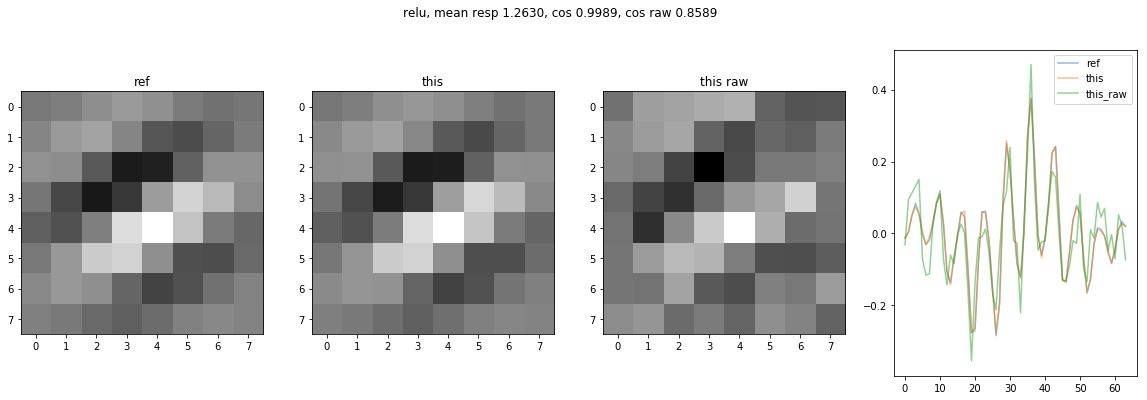

In [12]:

# let's try three different nonlinearites.
stim_out_linear_nonwhite = stim_in_nonwhite@kernel_to_recover.ravel()
out_dict_nonwhite = OrderedDict()

# square
out_dict_nonwhite['square'] = stim_out_linear_nonwhite*2
# 0, 1 at threshold of 0
out_dict_nonwhite['threshold'] = np.where(stim_out_linear_nonwhite>=0, 1, 0)
# sigmoid
out_dict_nonwhite['sigmoid'] = sigmoid(stim_out_linear_nonwhite)
# relu
out_dict_nonwhite['relu'] = np.where(stim_out_linear_nonwhite>=0, stim_out_linear_nonwhite, 0)

def rta_non_white_data():
    
    svd_cov = svd(preprocessing.cov_matrix(stim_in_nonwhite))
    
    for out_name, out_this in out_dict_nonwhite.items():
        rta_this = rta.rta(stim_in_nonwhite, out_this[:,np.newaxis])
        # then compute correction.
        
        # comment this out, you would get lower cos value, such as 0.84 here.
        rta_this_old = rta_this
        rta_this = rta.correct_rta(rta_this, svd_cov)
        
        
        rta_reshaped = preprocessing.reshape_kernel(rta_this, kernel_shape, 1, 1, False)
        print(rta_reshaped.shape)
        
        
        rta_reshaped_old = preprocessing.reshape_kernel(rta_this_old, kernel_shape, 1, 1, False)
        # compute cosine between recovered and original
        this_one = norm_vector(rta_reshaped.ravel()).reshape(rta_reshaped.shape)[0,0]
        this_one_raw = norm_vector(rta_reshaped_old.ravel()).reshape(rta_reshaped_old.shape)[0,0]
        ref_one = norm_vector(kernel_to_recover.ravel()).reshape(kernel_to_recover.shape)
        # show two kernels (normalized)
        plt.close('all')
        fig, axes = plt.subplots(1,4, figsize=(20, 6))
        # min max
        vmin = min(this_one.min(), this_one_raw.min(), ref_one.min())
        vmax = min(this_one.max(), this_one_raw.max(), ref_one.max())
        fig.suptitle('{}, mean resp {:.4f}, cos {:.4f}, cos raw {:.4f}'.format(out_name, out_this.mean(),
                                                                                     cos_between(this_one.ravel(), ref_one.ravel()),
                                                                                    cos_between(this_one.ravel(), this_one_raw.ravel())))
        
        axes[0].imshow(ref_one, cmap='gray', vmin=vmin, vmax=vmax)
        axes[0].set_title('ref')
        axes[1].imshow(this_one, cmap='gray', vmin=vmin, vmax=vmax)
        axes[1].set_title('this')
        axes[2].imshow(this_one_raw, cmap='gray', vmin=vmin, vmax=vmax)
        axes[2].set_title('this raw')
        axes[3].plot(ref_one.ravel(),label='ref', alpha=0.5)
        axes[3].plot(this_one.ravel(),label='this', alpha=0.5)
        axes[3].plot(this_one_raw.ravel(),label='this_raw', alpha=0.5)
        axes[3].legend()
        plt.show()
        
rta_non_white_data()

In [13]:
# just an aside. in practice, the adjacent rows in data matrix should come from sliding windows from the same data time series
# this won't introduce correlation, as shown below.
rng_state.seed(0)
data_1 = rng_state.randn(5000000)  # this number has to be big. otherwise, the result could be something like 0.001.
data_2 = data_1[1:]
preprocessing.cov_matrix(np.asarray([data_1[:-1], data_2]).T)

array([[  9.99296236e-01,   1.53706364e-04],
       [  1.53706364e-04,   9.99295721e-01]])

suppose our window length is 3, and assume stimulus at each time bin is a scalar. we actually sample data this way.

1. we sample from a standard 1D Gaussian distribution, mark their sample points as $x_1, x_2, \ldots, x_k, \ldots$.
2. at time $k$, we use $s_k = [x_k, x_{k+1}, x_{k+2}]$


Essentially, we first generate a very long sequence $x_n$, and then at each time $k$, we pick adjacent 3 elements starting from $x_k$.

The problem is what's the distribution of $[x_k, x_{k+1}, x_{k+2}]$. More concretely, when I have $k$ approach infinity, what will the histogram $\hat{P}(y)$ (with smaller and smaller bins) approach?

It's standard, 3D Gaussian.

The trick is how to deal with the temporal correlation among data points. 

You can think of this way. If we don't start from time $x_k$. but $x_{3k}$.

Then the distribution is definitely 3D Gaussian, as there's no overlap among variables.

We can also start from $x_{3k+1}$ or $x_{3k+2}$. These subsampling would also give us 3D Gaussian variables.

Then in the end, we just interleave elements from standard 3D Gaussian distributions.

These random variables $[x_k, x_{k+1}, x_{k+2}]$ are definitely not independent, but the distribution of $[x_k, x_{k+1}, x_{k+2}]$ is Gaussian. Why? we can split $s_k$ into three groups. $s_1, s_3, \ldots$; $s_2, s_5; \ldots$, $s_3, s_6, \ldots$. These three groups separately will yield $\hat{P}(y)$ that has standard 3D gaussian as limit. When using all of them three, the results is their average, still a 3D Gaussian.

This is sufficient for RTA/RTC analysis.